Descargando los datos de prueba y test

<a href="https://www.bigdatauniversity.com"><img src = "https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width = 400, align = "center"></a>

<h1 align=center><font size = 5> Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first download the files:

This dataset is about past loans. The Loan_train.csv data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

And after importing the required libraries

In [1]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-06-08 22:41:38--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.06s   

2021-06-08 22:41:39 (363 KB/s) - ‘loan_train.csv’ saved [23101/23101]



In [2]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-06-08 22:41:39--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0.03s   

2021-06-08 22:41:39 (105 KB/s) - ‘loan_test.csv’ saved [3642/3642]



In [3]:
from sklearn.metrics import accuracy_score, jaccard_score, log_loss, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
import scipy.optimize as opt
from sklearn import svm
from math import sqrt
import pandas as pd
import numpy as np
import pylab as pl
import itertools
%matplotlib inline 

In [4]:
#Storing the movie information into a pandas dataframe
loan_train_df = pd.read_csv('loan_train.csv')
#Storing the user information into a pandas dataframe
final_validation_df = pd.read_csv('loan_test.csv')

In [5]:
len(loan_train_df)

346

### Exploring the dataset

In [6]:
loan_train_df.tail(5)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
341,394,394,COLLECTION,800,15,9/11/2016,9/25/2016,32,High School or Below,male
342,395,395,COLLECTION,1000,30,9/11/2016,10/10/2016,25,High School or Below,male
343,397,397,COLLECTION,800,15,9/12/2016,9/26/2016,39,college,male
344,398,398,COLLECTION,1000,30,9/12/2016,11/10/2016,28,college,male
345,399,399,COLLECTION,1000,30,9/12/2016,10/11/2016,26,college,male


In [7]:
loan_train_df.describe()

,Unnamed: 0,Unnamed: 0.1,Principal,terms,age
count,346.000000,346.000000,346.000000,346.000000,346.000000
mean,202.167630,202.167630,943.641618,22.653179,30.939306
std,115.459715,115.459715,109.425530,7.991006,6.039418
min,0.000000,0.000000,300.000000,7.000000,18.000000
25%,107.250000,107.250000,900.000000,15.000000,27.000000
50%,204.500000,204.500000,1000.000000,30.000000,30.000000
75%,298.750000,298.750000,1000.000000,30.000000,35.000000
max,399.000000,399.000000,1000.000000,30.000000,51.000000


In [8]:
loan_train_df.dtypes

Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

### Preprocessing and Transforming datetime columns and creating news features

In [9]:
loan_train_df['effective_date'] = pd.to_datetime(loan_train_df['effective_date'])
loan_train_df['due_date'] = pd.to_datetime(loan_train_df['due_date'])
# creatting news features
loan_train_df['diff_days'] = (loan_train_df['due_date']-loan_train_df['effective_date']).dt.days
loan_train_df['day_of_pay'] = loan_train_df['effective_date'].dt.day
loan_train_df['day_of_week_pay'] = loan_train_df['effective_date'].dt.dayofweek

# applying the same to test df
final_validation_df['effective_date'] = pd.to_datetime(final_validation_df['effective_date'])
final_validation_df['due_date'] = pd.to_datetime(final_validation_df['due_date'])
# creatting news features
final_validation_df['diff_days'] = (final_validation_df['due_date']-final_validation_df['effective_date']).dt.days
final_validation_df['day_of_pay'] = final_validation_df['effective_date'].dt.day
final_validation_df['day_of_week_pay'] = final_validation_df['effective_date'].dt.dayofweek

#### Dropping first and second columns because it looks index and have the same values

In [10]:
all(loan_train_df['Unnamed: 0'] == loan_train_df['Unnamed: 0.1'])

True

In [11]:
loan_train_df = loan_train_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
final_validation_df = final_validation_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
loan_train_df.head(5)

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,diff_days,day_of_pay,day_of_week_pay
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,29,8,3
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,29,8,3
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,14,8,3
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,29,9,4
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,29,9,4


In [12]:
loan_train_df.groupby(['education', 'Gender'])['loan_status'].value_counts(normalize=True)

education             Gender  loan_status
Bechalor              female  PAIDOFF        1.000000
                      male    PAIDOFF        0.676471
                              COLLECTION     0.323529
High School or Below  female  PAIDOFF        0.800000
                              COLLECTION     0.200000
                      male    PAIDOFF        0.732824
                              COLLECTION     0.267176
Master or Above       male    COLLECTION     0.500000
                              PAIDOFF        0.500000
college               female  PAIDOFF        0.863636
                              COLLECTION     0.136364
                      male    PAIDOFF        0.748031
                              COLLECTION     0.251969
Name: loan_status, dtype: float64

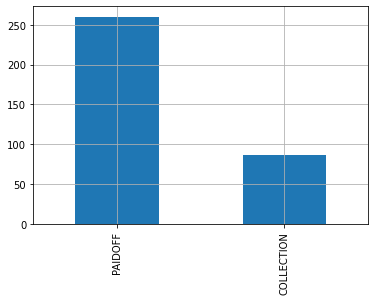

In [13]:
loan_train_df['loan_status'].value_counts().plot(kind='bar')
plt.grid()

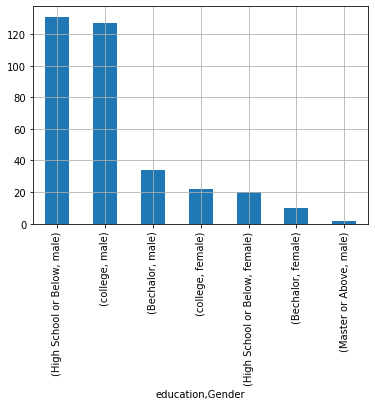

In [14]:
# loan_train_df[['education', 'Gender']].value_counts()
loan_train_df[['education', 'Gender']].value_counts().plot(kind='bar')
plt.grid()

### Getting the main columns values and get their values for X_train and X_test

In [15]:
columns_x = ['Principal', 'terms', 'age', 'education', 'Gender', 'diff_days', 'diff_days', 'day_of_pay', 'day_of_week_pay']
X = loan_train_df[columns_x].values  #.astype(float)
X_final_test = final_validation_df[columns_x].values
Y = loan_train_df['loan_status'].values
y_final_test = final_validation_df['loan_status'].values

### Encoding some variables as gender, education for X and Y and X and Y from the final validations df

In [16]:
le_gender = preprocessing.LabelEncoder()
le_gender.fit(loan_train_df.Gender.unique().tolist())
idx = columns_x.index('Gender')
X[:,idx] = le_gender.transform(X[:,idx])
X_final_test[:,idx] = le_gender.transform(X_final_test[:,idx]) 


le_edu = preprocessing.LabelEncoder()
le_edu.fit(loan_train_df.education.unique())
idx = columns_x.index('education')
X[:,idx] = le_edu.transform(X[:,idx])
X_final_test[:,idx] = le_edu.transform(X_final_test[:,idx])
del idx

le_status = preprocessing.LabelEncoder()
le_status.fit(loan_train_df.loan_status.unique())
Y = le_status.transform(Y)
y_final_test = le_status.transform(y_final_test)

### Splitting X and Y for train and test

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    Y, 
    test_size=0.2, 
    random_state=4)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 9) (276,)
Test set: (70, 9) (70,)


In [18]:
X_train[0:5]

array([[1000, 15, 35, 3, 1, 14, 14, 12, 0],
       [1000, 30, 26, 1, 1, 29, 29, 11, 6],
       [1000, 30, 31, 3, 1, 29, 29, 14, 2],
       [1000, 15, 25, 3, 1, 14, 14, 11, 6],
       [1000, 30, 28, 3, 1, 29, 29, 14, 2]], dtype=object)

In [19]:
#Normalize the data
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))
X_final_test = preprocessing.StandardScaler().fit(X_train).transform(X_final_test.astype(float))
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))
X_train[0:5]

array([[ 0.56081126, -0.9677917 ,  0.69858179,  1.15686159,  0.40565621,
        -0.87391174, -0.87391174,  0.41613766, -1.38869051],
       [ 0.56081126,  0.9437816 , -0.81959596, -0.58791327,  0.40565621,
         0.5393674 ,  0.5393674 , -0.428377  ,  0.91558954],
       [ 0.56081126,  0.9437816 ,  0.02383612,  1.15686159,  0.40565621,
         0.5393674 ,  0.5393674 ,  2.10516697, -0.62059716],
       [ 0.56081126, -0.9677917 , -0.98828237,  1.15686159,  0.40565621,
        -0.87391174, -0.87391174, -0.428377  ,  0.91558954],
       [ 0.56081126,  0.9437816 , -0.48222312,  1.15686159,  0.40565621,
         0.5393674 ,  0.5393674 ,  2.10516697, -0.62059716]])

# Trainning  a KNN  model

Finding the best K

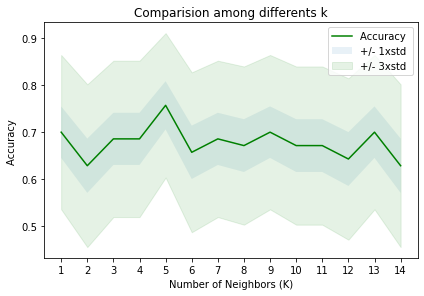

In [20]:
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1, Ks):
    # Train Model and Predict
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat == y_test) / np.sqrt(yhat.shape[0])

plt.plot(range(1, Ks), mean_acc, 'g')
plt.fill_between(
    range(1, Ks),
    mean_acc - 1 * std_acc,
    mean_acc + 1 * std_acc,
    alpha=0.10)
plt.fill_between(
    range(1, Ks),
    mean_acc - 3 * std_acc,
    mean_acc + 3 * std_acc,
    alpha=0.10,
    color="green")
plt.legend(('Accuracy ', '+/- 1xstd', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.title('Comparision among differents k')
plt.xticks(range(1, 15))
plt.show()

The best k neighbors is 5

In [21]:
k = 5
# Train Model and Predict
neigh = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
neigh

KNeighborsClassifier()

In [22]:
print("Train set Accuracy jaccard: ",
      jaccard_score(y_train, neigh.predict(X_train), average='binary'))
print("Train set Accuracy f1 score: ",
      f1_score(y_train, neigh.predict(X_train), average='weighted'))
print("Train set Accuracy log loss: ",
      log_loss(y_train, neigh.predict(X_train)), '\n')

print("Test set Accuracy jaccard: ",
      jaccard_score(y_test, neigh.predict(X_test), average='binary'))
print("Test set Accuracy f1 score: ",
      f1_score(y_test, neigh.predict(X_test), average='weighted'))
print("Test set Accuracy log loss: ",
      log_loss(y_test, neigh.predict(X_test)), '\n')

print("File test Accuracy jaccard: ",
      jaccard_score(y_final_test, neigh.predict(X_final_test), average='binary'))
print("File test Accuracy f1 score: ",
      f1_score(y_final_test, neigh.predict(X_final_test), average='weighted'))
print("File test Accuracy log loss: ",
      log_loss(y_final_test, neigh.predict(X_final_test)))

Train set Accuracy jaccard:  0.7669491525423728
Train set Accuracy f1 score:  0.7972308143823106
Train set Accuracy log loss:  6.882816990001534 

Test set Accuracy jaccard:  0.734375
Test set Accuracy f1 score:  0.7540496161185816
Test set Accuracy log loss:  8.38809135843362 

File test Accuracy jaccard:  0.7115384615384616
File test Accuracy f1 score:  0.6704776923582364
File test Accuracy log loss:  9.594282242459677


# Trainning  a Decision Tree model

In [23]:
deTree = DecisionTreeClassifier(criterion="entropy", max_depth=4)
deTree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [24]:
print("Train set Accuracy jaccard: ",
      jaccard_score(y_train, deTree.predict(X_train), average='binary'))
print("Train set Accuracy f1 score: ",
      f1_score(y_train, deTree.predict(X_train), average='weighted'))
print("Train set Accuracy log loss: ",
      log_loss(y_train, deTree.predict(X_train)), '\n')

print("Test set Accuracy jaccard: ",
      jaccard_score(y_test, deTree.predict(X_test), average='binary'))
print("Test set Accuracy f1 score: ",
      f1_score(y_test, deTree.predict(X_test), average='weighted'))
print("Test set Accuracy log loss: ",
      log_loss(y_test, deTree.predict(X_test)), '\n')

print("File test Accuracy jaccard: ",
      jaccard_score(y_final_test, deTree.predict(X_final_test), average='binary'))
print("File test Accuracy f1 score: ",
      f1_score(y_final_test, deTree.predict(X_final_test), average='weighted'))
print("File test Accuracy log loss: ",
      log_loss(y_final_test, deTree.predict(X_final_test)))

Train set Accuracy jaccard:  0.6916299559471366
Train set Accuracy f1 score:  0.757416213768116
Train set Accuracy log loss:  8.759898328939174 

Test set Accuracy jaccard:  0.5846153846153846
Test set Accuracy f1 score:  0.6376654046556961
Test set Accuracy log loss:  13.322213694812719 

File test Accuracy jaccard:  0.7407407407407407
File test Accuracy f1 score:  0.6304176516942475
File test Accuracy log loss:  8.95470488690319


# Trainning  a SVM model

In [25]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC()

In [26]:
print("Train set Accuracy jaccard: ",
      jaccard_score(y_train, clf.predict(X_train), average='binary'))
print("Train set Accuracy f1 score: ",
      f1_score(y_train, clf.predict(X_train), average='weighted'))
print("Train set Accuracy log loss: ",
      log_loss(y_train, clf.predict(X_train)), '\n')

print("Test set Accuracy jaccard: ",
      jaccard_score(y_test, clf.predict(X_test), average='binary'))
print("Test set Accuracy f1 score: ",
      f1_score(y_test, clf.predict(X_test), average='weighted'))
print("Test set Accuracy log loss: ",
      log_loss(y_test, clf.predict(X_test)), '\n')

print("File test Accuracy jaccard: ",
      jaccard_score(y_final_test, clf.predict(X_final_test), average='binary'))
print("File test Accuracy f1 score: ",
      f1_score(y_final_test, clf.predict(X_final_test), average='weighted'))
print("File test Accuracy log loss: ",
      log_loss(y_final_test, clf.predict(X_final_test)))

Train set Accuracy jaccard:  0.7565543071161048
Train set Accuracy f1 score:  0.6956017264571404
Train set Accuracy log loss:  8.134311741702415 

Test set Accuracy jaccard:  0.782608695652174
Test set Accuracy f1 score:  0.7151055544168887
Test set Accuracy log loss:  7.401326289824044 

File test Accuracy jaccard:  0.7407407407407407
File test Accuracy f1 score:  0.6304176516942475
File test Accuracy log loss:  8.95470488690319


# Trainning  a Logistic Regression model

In [27]:
logReg = LogisticRegression(C=0.01, solver='liblinear')
logReg.fit(X_train, y_train)

LogisticRegression(C=0.01, solver='liblinear')

In [28]:
print("Train set Accuracy jaccard: ",
      jaccard_score(y_train, logReg.predict(X_train), average='binary'))
print("Train set Accuracy f1 score: ",
      f1_score(y_train, logReg.predict(X_train), average='weighted'))
print("Train set Accuracy log loss: ",
      log_loss(y_train, logReg.predict(X_train)), '\n')

print("Test set Accuracy jaccard: ",
      jaccard_score(y_test, logReg.predict(X_test), average='binary'))
print("Test set Accuracy f1 score: ",
      f1_score(y_test, logReg.predict(X_test), average='weighted'))
print("Test set Accuracy log loss: ",
      log_loss(y_test, logReg.predict(X_test)), '\n')

print("File test Accuracy jaccard: ",
      jaccard_score(y_final_test, logReg.predict(X_final_test), average='binary'))
print("File test Accuracy f1 score: ",
      f1_score(y_final_test, logReg.predict(X_final_test), average='weighted'))
print("File test Accuracy log loss: ",
      log_loss(y_final_test, logReg.predict(X_final_test)))

Train set Accuracy jaccard:  0.7161016949152542
Train set Accuracy f1 score:  0.7598763606355048
Train set Accuracy log loss:  8.384502920215043 

Test set Accuracy jaccard:  0.6029411764705882
Test set Accuracy f1 score:  0.6187375808565511
Test set Accuracy log loss:  13.322247963274014 

File test Accuracy jaccard:  0.2682926829268293
File test Accuracy f1 score:  0.4337606837606838
File test Accuracy log loss:  19.188223915643533


## REPORT from test file

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.711   | 0.670    |  9.594  |
| Decision Tree      | 0.740   | 0.630    |  8.954  |
| SVM                | 0.740   | 0.630    |  8.954  |
| LogisticRegression | 0.268   | 0.433    |  19.188 |

## REPORT from test train

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.734   |   0.754  |  8.388  |
| Decision Tree      | 0.584   |   0.637  |  13.322 |
| SVM                | 0.782   |   0.715  |  7.401  |
| LogisticRegression | 0.602   |   0.618  |  13.322 |